In [1]:
import opendssdirect as dss
import os
import pathlib
import numpy as np
import pandas as pd
import random
import sys

In [2]:
dss.__version__
dss.run_command('Redirect C:/Users/smartgrid_AI/Documents/kms/Hyundai/ieee37.dss')
dss.run_command("New Energymeter.M1  Line.L1  1")
dss.Solution.Solve()

In [3]:
allbusname = dss.Circuit.AllBusNames()
busmagpu = dss.Circuit.AllBusMagPu()
allbus = np.array(allbusname)
busmagpu3 = np.array(busmagpu).reshape(-1,3)
BusXY = 'C:/Users/smartgrid_AI/Documents/kms/Hyundai/IEEE37_BusXY.csv'
busposition = pd.read_csv(BusXY, encoding='CP949', header=None)
BusVol = np.concatenate([allbus.reshape(-1,1), busmagpu3], axis=1)
Volavg = np.average(busmagpu3[2:-1], axis=1)
PVcandnum = 10
PVcandind = np.argpartition(Volavg,PVcandnum)[:PVcandnum]
PVcand = BusVol[PVcandind+2, 0]

PVcand

array(['741', '740', '738', '737', '736', '711', '735', '734', '710',
       '733'], dtype='<U32')

In [4]:
max_iter = 1
PVnum = 4
pv_location=[]

dss.run_command("New Loadshape.MyIrrad npts=24 interval=1 mult=[0	0	0	0	0	0	0.060635269	0.334303652	0.712509398	1.188145406	1.519300343	1.633283854	1.720008482	1.7748861	1.635712863	1.448499219	1.085587235	0.635140953	0.224818306	0.027168919	0	0	0	0]")
dss.run_command("New Loadshape.MyLoad npts=24 interval=1 mult=[0.88649465	0.847586893	0.824626468	0.810807748	0.808050417	0.81543569	0.854856043	0.918443729	1.011297018	1.074020336	1.104456893	1.115341911	1.083370481	1.122746619	1.136014359	1.130316038	1.129009039	1.112199769	1.092962104	1.084670677	1.072273622	1.032156527	0.982890926	0.949972043]")
dss.run_command("New PVSystem.PV conn=Delta phases=3 bus=701 kV=4.8 irrad=1.0 Pmpp=400 kVA=400 Daily=MyIrrad")
dss.run_command("New monitor.L1 Load.S701a terminal=1 mode=1 ppolar=no")
dss.run_command("New monitor.PV PVSystem.PV terminal=1 mode=1 ppolar=no")
#for k in range(0,max_iter):
    
# Select random PV location
pv_location=random.sample(list(PVcand),PVnum)

# Locate PVs with fixed size
for m in range(1,PVnum+1):
    pv_kva_text="New PVSystem.PV"+str(m)+" conn=Delta phases=3 bus="+str(pv_location[m-1])+" kV=4.8 irrad=1.0 Pmpp=400 temperature=25 PF=.95 kVA=400 Daily=MyIrrad"
    dss.run_command(pv_kva_text)
pvnum = dss.PVsystems.Count()

allLoad_name = dss.Loads.AllNames()
for loadname in allLoad_name:
    dss.run_command("Load."+loadname+".daily=MyLoad")
allPV_name = dss.PVsystems.AllNames()
for pvname in allPV_name:
    dss.run_command("PVSystem."+pvname+".daily=MyIrrad")

In [5]:
dss.utils.pvsystems_to_dataframe()

,Irradiance,Name,pf,RegisterNames,RegisterValues,Idx,kVARated,kW,kvar,IrradianceNow,Pmpp,daily,duty,yearly,Tdaily,Tduty,Tyearly
pv,1,pv,1,"[kWh, kvarh, Max kW, Max kVA, Hours, Price($)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1,400,400,0,1,400,myirrad,,,,,
pv1,1,pv1,0.95,"[kWh, kvarh, Max kW, Max kVA, Hours, Price($)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2,400,377.776,131.474,1,400,myirrad,,,,,
pv2,1,pv2,0.95,"[kWh, kvarh, Max kW, Max kVA, Hours, Price($)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",3,400,377.776,131.474,1,400,myirrad,,,,,
pv3,1,pv3,0.95,"[kWh, kvarh, Max kW, Max kVA, Hours, Price($)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",4,400,377.776,131.474,1,400,myirrad,,,,,
pv4,1,pv4,0.95,"[kWh, kvarh, Max kW, Max kVA, Hours, Price($)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",5,400,377.776,131.474,1,400,myirrad,,,,,


In [6]:
Load_df = dss.utils.loads_to_dataframe()
Load_df.iloc[:,6:-6]

,IsDelta,Model,Name,NumCust,PF,PctMean,PctStdDev,RelWeighting,Rneut,Spectrum,...,Xneut,Yearly,ZipV,Daily,Duty,Idx,kV,kW,kVABase,kvar
s701a,True,1,s701a,1,0.894427,50,10,1,-1,defaultload,...,0,default,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",myload,,1,4.8,140,156.525,70
s701b,True,1,s701b,1,0.894427,50,10,1,-1,defaultload,...,0,myload,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",myload,,2,4.8,140,156.525,70
s701c,True,1,s701c,1,0.894427,50,10,1,-1,defaultload,...,0,myload,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",myload,,3,4.8,350,391.312,175
s712c,True,1,s712c,1,0.904819,50,10,1,-1,defaultload,...,0,myload,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",myload,,4,4.8,85,93.9415,40
s713c,True,1,s713c,1,0.904819,50,10,1,-1,defaultload,...,0,myload,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",myload,,5,4.8,85,93.9415,40
s714a,True,4,s714a,1,0.904819,50,10,1,-1,defaultload,...,0,myload,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",myload,,6,4.8,17,18.7883,8
s714b,True,4,s714b,1,0.902861,50,10,1,-1,defaultload,...,0,myload,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",myload,,7,4.8,21,23.2594,10
s718a,True,2,s718a,1,0.904819,50,10,1,-1,defaultload,...,0,myload,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",myload,,8,4.8,85,93.9415,40
s720c,True,1,s720c,1,0.904819,50,10,1,-1,defaultload,...,0,myload,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",myload,,9,4.8,85,93.9415,40
s722b,True,4,s722b,1,0.894427,50,10,1,-1,defaultload,...,0,myload,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",myload,,10,4.8,140,156.525,70


In [7]:
dss.run_command("set mode=duty stepsize=1h")
dss.Solution.ControlMode = "time"
dss.Solution.MaxControlIterations = 1000

In [8]:
V_list = []
dss.Solution.Hour = 0
for i in range (25):    
    dss.Solution.InitSnap()
    dss.Solution.SolvePlusControl()
    dss.run_command("Plot monitor object=L1 channels=(1)")
    dss.run_command("Export monitors L1")
    dss.run_command("Export monitors PV")
    dss.run_command("Export Voltages")
    #return outputList
    dss.Solution.FinishTimeStep()
    dss.Solution.Hour = dss.Solution.Hour+1
    #dss.run_command("Show Taps")
    #dss.run_command("Show Powers kVA Elem")
    volts = dss.Circuit.AllBusMagPu()
    V_list.append(volts)

dss.Monitors.SaveAll()    

In [9]:
V_list = np.array(V_list)
V_list[:,3]

array([0.92045212, 0.92632407, 0.92988159, 0.93196053, 0.93321078,
       0.93345738, 0.93279773, 0.92922208, 0.93791187, 0.94479235,
       0.94968755, 0.94673069, 0.94580033, 0.94837227, 0.94512384,
       0.94399457, 0.94441779, 0.94447842, 0.93275244, 0.91672985,
       0.90646087, 0.90767623, 0.91181153, 0.91683939, 0.9200644 ])

In [10]:
buspos = busposition.iloc[:,0]
buspos = buspos.values
newpos = np.zeros([len(busposition),2])
for i in range(len(BusVol)):
    ind = np.where(buspos == BusVol[i,0])
    newpos[i,:] = busposition.iloc[ind[0][0],1:]  

In [11]:
BusDat = np.concatenate([BusVol, newpos], axis=1)

In [12]:
dss.Lines.First()
name, B1, B2 = list(), list(), list()

while True:
    a = dss.Lines.Name()
    b = dss.Lines.Bus1()
    c = dss.Lines.Bus2()
    b = b.replace('.1.2.3','')
    c = c.replace('.1.2.3','')
    name.append(a),
    B1.append(b),
    B2.append(c)
    if not dss.Lines.Next() > 0:
        break

(0.0, 1.5)

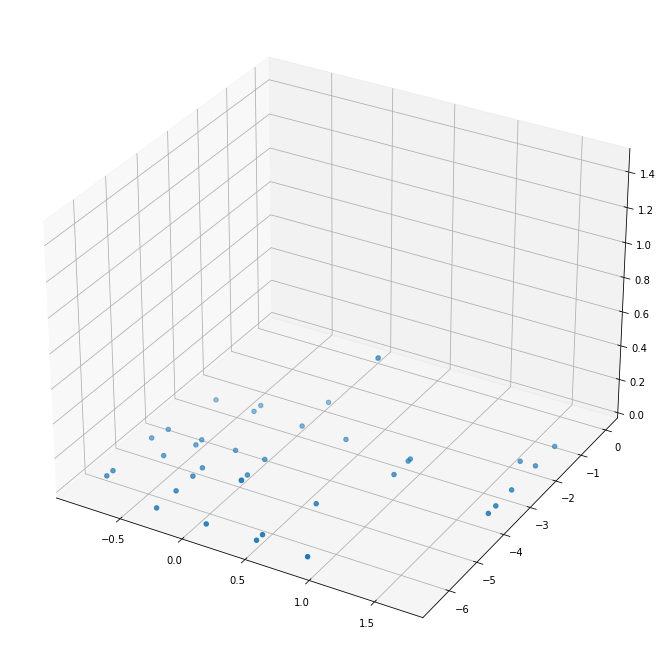

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(newpos[:,0], newpos[:,1], 0)
ax.set_zlim3d(0, 1.5)